Scrapping the old pressure test and rewriting from scratch

### Notes
* It looks like the Y matrix values are opposite. I should probably multiply by -1.
* gradW should be returning values on the order of e-35
* Current values of dt and h are not finalized

### Imports

In [660]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import animation
from matplotlib.collections import PatchCollection

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb

Populating the interactive namespace from numpy and matplotlib


### Constants

In [661]:
dt = 1e0
stepN = 6000

### Initialize position, velocity, mass, pressure, density, and time

In [662]:
### --- Distribution Case 1 --- ###
xyDistribution = np.array(([1.0e8, 1.0e8], 
                           [-1.0e8, -1.0e8]))
#                           [-1.0e8, 1.0e8]))
nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
# nParticles = 50
# xyDistribution = np.random.normal(0,100, size=(nParticles, 2))

velocityDistribution = np.zeros_like(xyDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles,2,stepN))


timeArray = np.arange(0, stepN*dt, dt)

[]

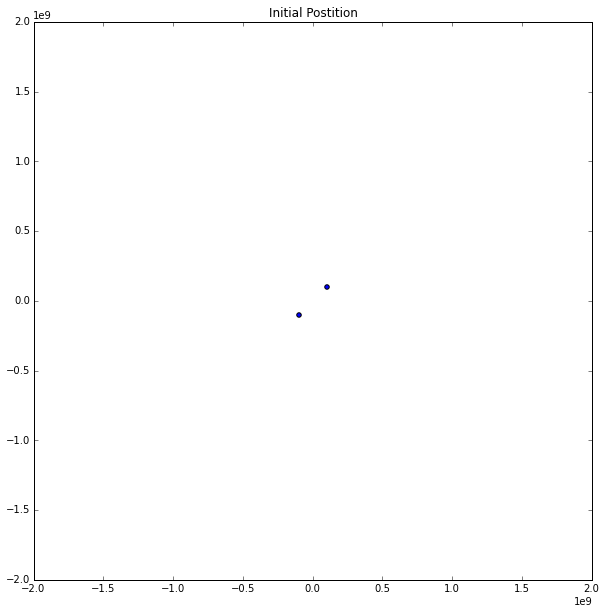

In [663]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.xlim(-2e9, 2e9)
plt.ylim(-2e9, 2e9)
plt.title("Initial Postition")
plt.plot()

In [664]:
h = 3e8
distMatrix = cdist(xyDistribution, xyDistribution)
print "True distance:\n", distMatrix
X = np.zeros_like(distMatrix)
Y = np.zeros_like(distMatrix)
for i in range(nParticles):
    particle_i = xyDistribution[i]
    
    deltaX = particle_i[0] - xyDistribution[:,0]
    deltaY = particle_i[1] - xyDistribution[:,1]
    X[:,i] = deltaX
    Y[:,i] = deltaY
    
distMatrix1 = distMatrix < h
R1 = distMatrix1 * distMatrix
X1 = distMatrix1 * X
Y1 = distMatrix1 * Y

W1 = np.array(
              [3*X1*R1/(4*h)-X1,
               3*Y1*R1/(4*h)-Y1]
              ) * distMatrix1/(np.pi*h**5)

W1 = np.sum(W1, axis=1)

print W1

True distance:
[[  0.00000000e+00   2.82842712e+08]
 [  2.82842712e+08   0.00000000e+00]]
[[ -7.67331746e-36   7.67331746e-36]
 [ -7.67331746e-36   7.67331746e-36]]


### Define smoothing gradient

In [665]:
def gradW(h=2e9, verbose=False):
    h = 3e8
    distMatrix = cdist(xyDistribution, xyDistribution)
    X = np.zeros_like(distMatrix)
    Y = np.zeros_like(distMatrix)
    for i in range(nParticles):
        particle_i = xyDistribution[i]

        deltaX = particle_i[0] - xyDistribution[:,0]
        deltaY = particle_i[1] - xyDistribution[:,1]
        X[:,i] = deltaX
        Y[:,i] = deltaY

    distMatrix1 = distMatrix < h
    R1 = distMatrix1 * distMatrix
    X1 = distMatrix1 * X
    Y1 = distMatrix1 * Y

    W1 = np.array(
                  [3*X1*R1/(4*h)-X1,
                   3*Y1*R1/(4*h)-Y1]
                  ) * distMatrix1/(np.pi*h**5)

    W1 = np.sum(W1, axis=1)

    return W1.T

In [666]:
print gradW()

[[ -7.67331746e-36  -7.67331746e-36]
 [  7.67331746e-36   7.67331746e-36]]


In [667]:
def gradP():
    gradPX = mDistribution*pressureDistribution/rhoDistribution \
        * gradW(xyDistribution)[:,0]
        
    gradPY = mDistribution*pressureDistribution/rhoDistribution \
        * gradW(xyDistribution)[:,1]
    return np.array((gradPX, gradPY)).T

In [668]:
print gradP().shape
print ParticleVelocityHistory.shape
print -gradP()

(2L, 2L)
(2L, 2L, 6000L)
[[ 204621.79894544  204621.79894544]
 [-204621.79894544 -204621.79894544]]


### RK1

In [669]:
t = 0
for i in range(stepN):
#    print gradP()
    t += 1
    ParticlePositionHistory[:,:,i] = xyDistribution
    deltaV = -gradP()/rhoDistribution[:,np.newaxis] * dt
    velocityDistribution += deltaV
    deltaPos = velocityDistribution * dt
    xyDistribution += deltaPos
#    print "deltaV at timestep", t, "\n", deltaV
#    print "deltaPos at timestep", t, "\n", deltaPos
#    print "velocityDistribution at timestep", t, "\n", velocityDistribution

#     print "deltaPos:\n", deltaPos
#     print "xyDistribution:\n", xyDistribution

#     ParticleVelocityHistory[:,:,i] = -gradP()/rhoDistribution[:,np.newaxis] * dt


In [670]:
print ParticlePositionHistory[:,:,3]

[[  1.00408914e+08   1.00408914e+08]
 [ -1.00408914e+08  -1.00408914e+08]]


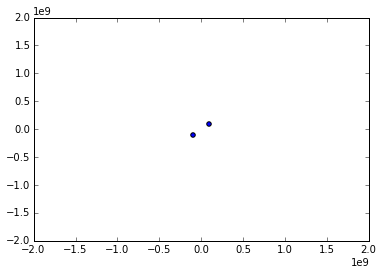

In [671]:
slider = FloatSlider(description='Time', min=0, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[:,0,time]
    y = ParticlePositionHistory[:,1,time]
    fig = plt.figure()
    plt.scatter(x, y)
    plt.xlim(-2e9, 2e9)
    plt.ylim(-2e9, 2e9)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()